<a href="https://colab.research.google.com/github/dagnert/Big_Data/blob/master/Big_Data_Tizian_Dagner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NYC fare prediction

<img src="https://upload.wikimedia.org/wikipedia/commons/3/35/New_York_Taxi.JPG" alt="taxi" style="width:400px;height:250px;">

Kaggle Score: 3.01618 <br>
Kaggle Name: tizdag <br>
Kaggle ID: 5124789 <br>
Leaderboard position: 247 (theoretical placement, competition already finished) <br>

Cooperation with: Alexander Sperka

This notebook shows my approach for predicting the fare amount for a taxi ride in NYC when given the pickup and dropoff locations of the passangers regarding the [New York City Taxi Fare Prediction Challange]( https://www.kaggle.com/c/new-york-city-taxi-fare-prediction).



---

This notebook is seperated into different sections, relating to the common data science workflow (except the hypothesis and data collection where already done).


0.   Previous Commits
1.   Setup and Check Infrastructure
2.   Having a first look at the Data (EDA)
3.   Data Cleaning (Feature Engineering)
4.   Functions for all models
5.   Comparing CPU and GPU Linear Regression
6.   K-Nearest Neighbors Regression GPU
7.   Comparing CPU and GPU Random Forest
8.   Comparing CPU and GPU Ridge Regression
9.   XGBoost running on GPU
10.  XGBoost CPU
11.  LGBM model setup (not executable on Kaggle)
12.  Evaluation and Discussion

---




# 0. Previous Commits - Comparison of different Models:



Predictions are done when using the whole data set

### Linear Regression

**Commit 1 (Baseline) Score: 4.56121**
- fit_intercept=True
- normalize=False,
- n_jobs=-1
- data_size = 5.5 Mio rows (1 %)

### K-Nearest Neighbor 
**Commit 2 Score: 4.87676**
  - n_neighbors = 4
  - data_size = 5.5 Mio rows (1 %)

### Random Forest 
**Commit 3 Score: 5.63070**
  - n_estimators=10
  - max_depth=16
  - n_jobs=-1
  - data_size = 5.5 Mio rows (1 %)
  
### XGBoost
**Commit 4 Score: 3.01618**
- MAX_TREE_DEPTH = 12
- MIN_CHILD_WEIGHT = 2
- TREE_METHOD = "hist"
- ITERATIONS = 300
- SUBSAMPLE = 0.9
- REGULARIZATION = 1.4
- GAMMA = 0.4 
- POS_WEIGHT = 0.8
- EARLY_STOP = 20
- N_ESTIMATORS = 1000
- LEARNING = 0.15 
- data_size = 40.0 Mio rows (~70%)



# 1. Setup and Check Infrastructure

In [ ]:
## Switch from Kaggle to Colab easily
environment='Kaggle'

## when True only 50.000 rows are used for debugging purpose. Set to False when doing real training
debug_mode=False

## choose how many rows of the training data sample you would like to use (only works when debug_mode=False ), max is 40.000.000
rows_datasample=500000

In [ ]:
if environment == 'Kaggle':
  env_submission_path='./'
  env_path='../input/new-york-city-taxi-fare-prediction/'
  print('The environment and paths were successfully setup for Kaggle')
elif environment == 'Colab':
  env_submission_path='/content/drive/My Drive/Colab Notebooks/'
  env_path='/content/drive/My Drive/Colab Notebooks/'

  from google.colab import drive
  drive.mount('/content/drive')

  print('The environment and paths were successfully setup for Colab')

else:
  print('Something went wrong here, please choose one of the options for path completion: Kaggle or Colab (or implement your own thing)')


The environment and paths were successfully setup for Kaggle


Check for GPU and CPU

In [ ]:
!nvidia-smi

Wed Sep 30 15:06:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
!lscpu | grep "Model name:"
!lscpu | grep "CPU(s)"

Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz
CPU(s):              2
On-line CPU(s) list: 0,1
NUMA node0 CPU(s):   0,1


In [ ]:
if environment == 'Kaggle':
  import sys
  !cp ../input/rapids/rapids.0.14.0 /opt/conda/envs/rapids.tar.gz
  !cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
  sys.path = ["/opt/conda/envs/rapids/lib/python3.7/site-packages"] + sys.path
  sys.path = ["/opt/conda/envs/rapids/lib/python3.7"] + sys.path
  sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path 
  !cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/
  print('You are all set for the kaggle rapids environment')

elif environment == 'Colab':
  # Install RAPIDS and Dask_ml
  !pip install dask_ml
  !pip install dask_cuda

  !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
  !bash rapidsai-csp-utils/colab/rapids-colab.sh stable


  import sys, os

  dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
  sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
  sys.path
  exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())
    
  print('You are all set for the colab rapids environment')

else:
  print('Something went wrong here, please choose one of the options for path completion: Kaggle or Colab (or implement your own thing). If Kaggle failed please make sure you added the RAPIDS file on Kaggle to your Input!')

You are all set for the kaggle rapids environment


In [ ]:
import nvstrings
import numpy as np
import cudf, cuml
import dask_cudf
import io, requests
import math
import gc
import cupy as cp
import pandas as pd

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns 

#Learning
from cuml.preprocessing.model_selection import train_test_split
from scipy.stats import uniform

#Models https://github.com/rapidsai/cuml/tree/branch-0.13/notebooks
from cuml.linear_model import LinearRegression # Linear
from cuml.linear_model import LogisticRegression # Logisitc
from cuml.linear_model import Ridge # Ridge

from cuml.solvers import SGD as cumlSGD # Stochastic Gradient Descent
from cuml.ensemble import RandomForestRegressor as cuRF # Random Forest
from cuml.dask.ensemble import RandomForestClassifier as cumlDaskRF # RandomForest

from cuml.neighbors import KNeighborsRegressor as cumlKNR # Nearest Neighbours

from cuml import ForestInference
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from cuml.metrics.regression import r2_score
from cuml.metrics.accuracy import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score as sk_acc
from sklearn.utils.fixes import loguniform

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: nvstrings will be removed in 0.15. Please use equivalent from libcudf
  """Entry point for launching an IPython kernel.


# 2. First look at the Data

In [ ]:
cudf.set_allocator("managed")
dtype = {
            'fare_amount': 'float32',
            'pickup_datetime':'str',
            'pickup_longitude': 'float32',
            'pickup_latitude': 'float32',
            'dropoff_longitude': 'float32',
            'dropoff_latitude': 'float32',
            'passenger_count': 'int8',
            'key':'str'
        }

usecols = list(dtype.keys())

In [ ]:
%%time
# use a subset with 50.000 rows, max is nrows = 12.542.348

if debug_mode != True:
  ## using 1% (or how much you like)
  nrows=rows_datasample
else:
  ## using a very small sample just for testing
  nrows = 50000

test = cudf.read_csv(env_path+'test.csv', usecols=usecols, dtype=dtype)
train = cudf.read_csv(env_path+'train.csv', nrows=nrows, usecols=usecols, dtype=dtype)
submission = cudf.read_csv(env_path+'sample_submission.csv', usecols=usecols, dtype=dtype)

CPU times: user 1.09 s, sys: 546 ms, total: 1.64 s
Wall time: 1.92 s


In [ ]:
train.head(5)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844307,40.721321,-73.841614,40.712273,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016045,40.711304,-73.979271,40.782005,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982742,40.761269,-73.991234,40.750565,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987137,40.733139,-73.991570,40.758095,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968102,40.768009,-73.956665,40.783768,1


In [ ]:
test.head(5)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739197,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982536,40.751259,-73.979668,40.746140,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981163,40.767811,-73.990440,40.751633,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966042,40.789776,-73.988579,40.744431,1


# 3. Data Cleaning

In [ ]:
#Drop Nan Values
#train.nans_to_nulls()
train = train.dropna()
test = test.dropna()

In [ ]:
#Checking shape of the data
print("Train: " + str(train.shape))
print("Test: " + str(test.shape))

Train: (499995, 8)
Test: (9914, 7)


It can be seen that 5 data sets had missing values. Due to the small percentage, these data sets can be removed in order not to falsify the result.

In [ ]:
#Changing the data format of pickup_datetime and adding additional information about pickup time
train['pickup_datetime'] = train['pickup_datetime'].astype('datetime64[ns]')

#train["minute"] = train.pickup_datetime.dt.minute
train["hour"] = train.pickup_datetime.dt.hour
train["weekday"] = train.pickup_datetime.dt.weekday
train["month"] = train.pickup_datetime.dt.month
train["year"] = train.pickup_datetime.dt.year


test['pickup_datetime'] = test['pickup_datetime'].astype('datetime64[ns]')

#test["minute"] = test.pickup_datetime.dt.minute
test["hour"] = test.pickup_datetime.dt.hour
test["weekday"] = test.pickup_datetime.dt.weekday
test["month"] = test.pickup_datetime.dt.month
test["year"] = test.pickup_datetime.dt.year

The existing key pickup_datetime is broken down into its components in this step. It consists of the parameters year, month, day, hour and minute. The attribute second is neglected in this consideration.

In [ ]:
#calculate trip distance in miles
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

The distance of the driving distance is to be regarded as an elementary component. Since in the original ones only the coordinates of start and destination are given, a conversion of these is done. (https://www.kompf.de/gps/distcalc.html)

In [ ]:
train['distance'] = distance(train['pickup_latitude'], train['pickup_longitude'], train['dropoff_latitude'], train['dropoff_longitude'] )
test['distance'] = distance(test['pickup_latitude'], test['pickup_longitude'], test['dropoff_latitude'], test['dropoff_longitude'] )
train['distance'].describe()

count    499995.000000
mean         11.894358
std         228.239755
min           0.000000
25%           0.000000
50%           1.366828
75%           2.424684
max        7704.968750
Name: distance, dtype: float64

In [ ]:
#check if everything worked
train.head(2)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844307,40.721321,-73.841614,40.712273,1,17,0,6,2009,0.000000
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016045,40.711304,-73.979271,40.782005,1,16,1,1,2010,5.244397


In [ ]:
test.head(2)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year,distance
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,13,1,1,2015,1.366828
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739197,1,13,1,1,2015,1.366828


In [ ]:
print("Ararage fare amount: " + str(train['fare_amount'].mean()))
print("Standard deviation fare amount: " + str(train['fare_amount'].std()))
print("Ararage distance: " + str(train['distance'].mean()) + " miles")
print("Standard deviation distance: " + str(train['distance'].std()) + " miles")

Ararage fare amount: 11.358182056380917
Standard deviation fare amount: 9.916069031491416
Ararage distance: 11.894358346249913 miles
Standard deviation distance: 228.2397549126703 miles


The average distance and fare amount are for orientation. Based on this, the quality of a model can be roughly evaluated. If the deviation of the model is within one standard deviation, it is possible to predict at least 68.27% of all values, assuming a Gaussian bell curve.

In [ ]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year,distance
count,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000
mean,11.358182,-72.520092,39.920351,-72.522436,39.916526,1.683445,13.510843,3.042020,6.268617,2011.739129,11.894358
std,9.916069,11.856446,8.073318,11.797362,7.391003,1.307391,6.511596,1.949243,3.437798,1.860897,228.239755
min,-44.900002,-2986.242188,-3116.285156,-3383.296631,-2559.749023,0.000000,0.000000,0.000000,1.000000,2009.000000,0.000000
25%,6.000000,-73.992043,40.734921,-73.991371,40.734058,1.000000,9.000000,1.000000,3.000000,2010.000000,0.000000
50%,8.500000,-73.981789,40.752666,-73.980133,40.753151,1.000000,14.000000,3.000000,6.000000,2012.000000,1.366828
75%,12.500000,-73.967117,40.767078,-73.963570,40.768135,2.000000,19.000000,5.000000,9.000000,2013.000000,2.424684
max,500.000000,2140.601074,1703.092773,40.851025,404.616699,6.000000,23.000000,6.000000,12.000000,2015.000000,7704.968750


In [ ]:
print("Maximum distance Test: " + str(test['distance'].max()))
print("Maximum passenger Test: " + str(test['passenger_count'].max()))

Maximum distance Test: 62.140335
Maximum passenger Test: 6


Visualization of the data <br>

The following things were noticed (while using 5.5mio datapoints):
*   The minimal fare_amount is negative. As this does not seem to be realistic I will drop them from the dataset.
*   Some of the minimum and maximum longitude/lattitude coordinates are way off. These  will also be remove from the dataset. (bounding box will be defined)
*   The average fare_amount is about 11.35 USD with a standard deviation of 9.91 USD. When building a predictive model we want to be better than 9.81 USD and no negative values should be part of the result
*   The maximum distance in the test set is 62 miles, so all longer distances in the training set will be removed.
*   The maximum number of persons in the test set is 6. Rides in the training set with more people are also removed.




In [ ]:
train = train[train.fare_amount>=0]
train = train[(train['distance'] < 70) & (train['distance'] >=0 )]
train = train[(train['passenger_count'] < 6)]

In [ ]:
#This parameter had a not negligible influence on the prediction. Therefore it was also part of the optimization.
train = train[(train['fare_amount'] < 250)] 

In [ ]:
fare_amount = train['fare_amount'].to_array()
passenger_count = train['passenger_count'].to_array()
distance = train['distance'].to_array()
year = train['year'].to_array()
month = train['month'].to_array()
day = train['weekday'].to_array()
hour = train['hour'].to_array()

Text(0.5, 1.0, 'Verteilung des Fahrpreises')

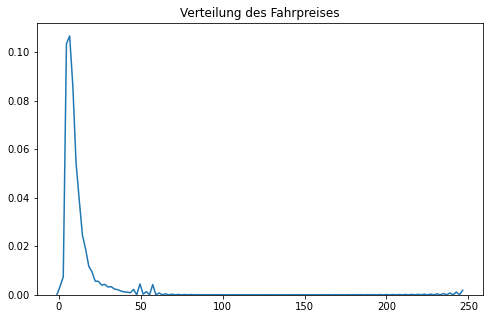

In [ ]:
plt.figure(figsize=(8,5))
sns.kdeplot(fare_amount).set_title("Verteilung des Fahrpreises")

Some of the data sets show a fare of 0, the background for this is not known. Most of the data is in the single-digit or low two-digit range. There are some outliers that show fares of $1000 or more, these can be removed as well.

Text(0.5, 1.0, 'Distanz')

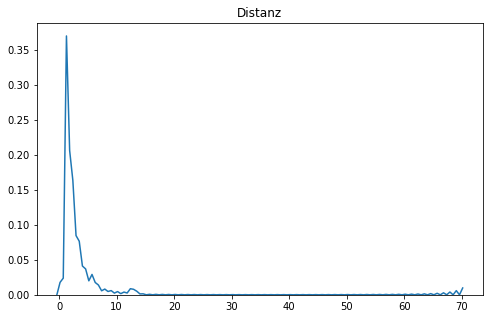

In [ ]:
plt.figure(figsize=(8,5))
sns.kdeplot(distance).set_title("Distanz")

Most of the driven routes show very short distances within New York with a maximum of 10 miles. At about 15 miles, there is an even greater frequency due to trips to the airports. A few long distances are over 50 miles, no reason is known.

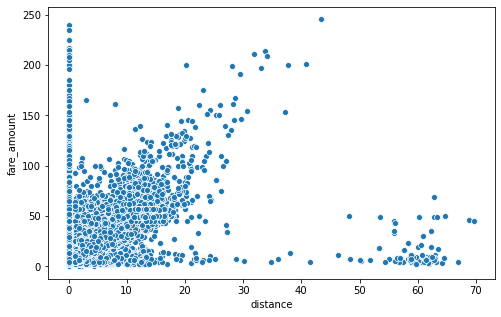

In [ ]:
train_plot = train.to_pandas()
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=train_plot, x="distance", y="fare_amount"
)

The relationship between distance and price seems almost linear. However, some records exist with a distance of about 60 miles and relatively low prices. This could be due to fixed prices.

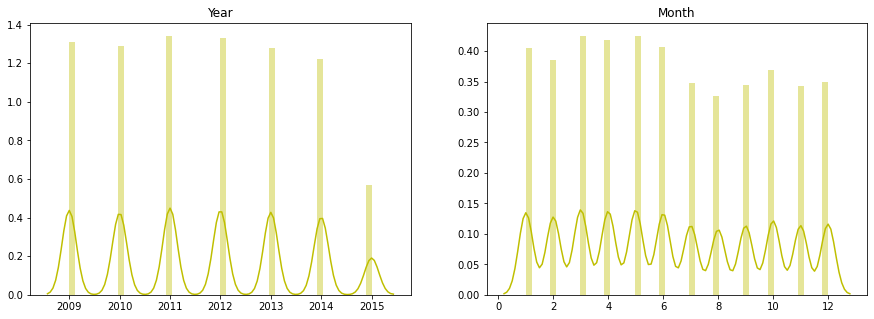

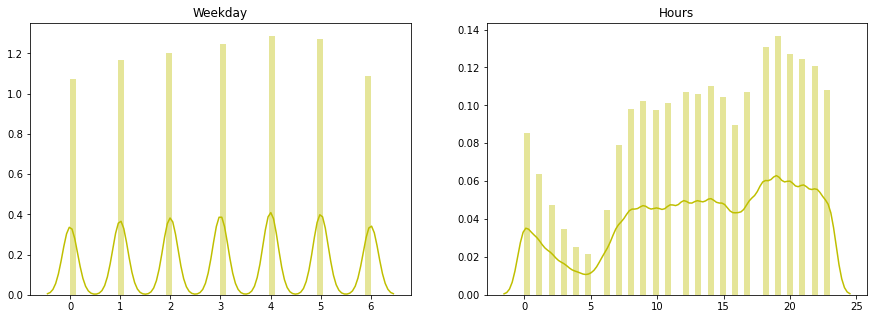

In [ ]:
fig,(ax1,ax2,)=plt.subplots(1,2,figsize=(15,5))
ax1.set_title('Year')
sns.distplot(year, ax=ax1, color="y")

ax2.set_title('Month')
sns.distplot(month, ax=ax2, color="y")
plt.show()

fig,(ax1,ax2,)=plt.subplots(1,2,figsize=(15,5))
ax1.set_title('Weekday')
sns.distplot(day, ax=ax1, color="y")

ax2.set_title('Hours')
sns.distplot(hour, ax=ax2, color="y")
plt.show()

It is shown that there are hardly any or comparatively small differences within the years and weekdays.   On the other hand, the fluctuations in terms of months and especially hours offer a starting point for further observations. However, it should be noted that certain travel times are less frequented and therefore a smaller data set is available. The analysis of the extent to which individual parameters influence the price is excluded at this point.

In [ ]:
#check max latitude und max longitude of test data
print("Max lat pickup: " + str(test['pickup_latitude'].max()))
print("Max lat dropoff: " + str(test['dropoff_latitude'].max()))
print("Max lon pickup: " + str(test['pickup_longitude'].max()))
print("Max lon dropoff: " + str(test['dropoff_longitude'].max()))
print("")
print("Min lat pickup: " + str(test['pickup_latitude'].min()))
print("Min lat dropoff: " + str(test['dropoff_latitude'].min()))
print("Min lon pickup: " + str(test['pickup_longitude'].min()))
print("Min lon dropoff: " + str(test['dropoff_longitude'].min()))

Max lat pickup: 41.709553
Max lat dropoff: 41.696682
Max lon pickup: -72.986534
Max lon dropoff: -72.99096

Min lat pickup: 40.57314
Min lat dropoff: 40.568974
Min lon pickup: -74.25219
Min lon dropoff: -74.26323


Bounding Box New York
<table>
  <tr>
    <th></th>
    <th>Dropoff</th>
    <th>Pickup</th>
  </tr>
  <tr>
    <td>Max Long</td>
    <td>-72.99096</td>
    <td>-72.986534</td>
   </tr>
   <tr>
    <td>Max Lat</td>
    <td>41.696682</td>
    <td>41.709553</td>
   </tr>
   <tr>
    <td>Min Long</td>
    <td>-74.26323</td>
    <td>-74.25219</td>
    </tr>
   <tr>
    <td>Min Lat</td>
    <td>40.568974</td>
    <td>40.57314</td>
   </tr>
</table>



In [ ]:
train.head(2)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844307,40.721321,-73.841614,40.712273,1,17,0,6,2009,0.000000
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016045,40.711304,-73.979271,40.782005,1,16,1,1,2010,5.244397


In [ ]:
#Parts of train data are too far away, so they can be dropped
train = train[(train['pickup_longitude'] > -74.25) & (train['pickup_longitude'] < -72.98)]
train = train[(train['pickup_latitude'] > 40.57) & (train['pickup_latitude'] < 41.70)]
train = train[(train['dropoff_longitude'] < -72.99) & (train['dropoff_longitude'] > -74.26)]
train = train[(train['dropoff_latitude'] > 40.56) & (train['dropoff_latitude'] < 41.69)]

(-74.03, -73.75)

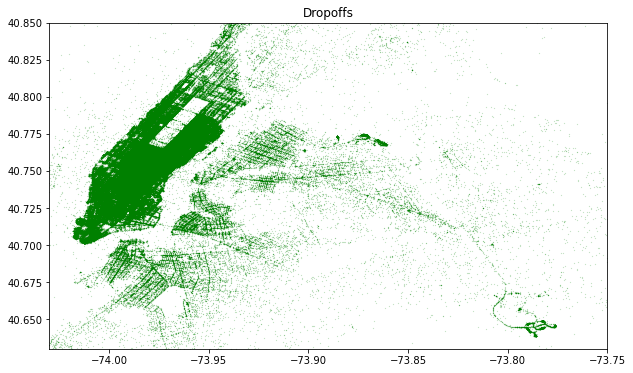

In [ ]:
dropoff_longitude = train['dropoff_longitude'].to_array()
dropoff_latitude = train['dropoff_latitude'].to_array()

city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

plt.figure(figsize=(10,6))
plt.scatter(dropoff_longitude, dropoff_latitude,
                color='green', 
                s=.02, alpha=.6)
plt.title("Dropoffs")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

(-74.03, -73.75)

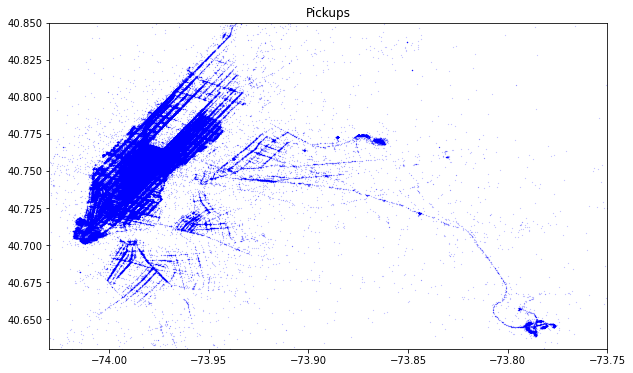

In [ ]:
dropoff_longitude = train['pickup_longitude'].to_array()
dropoff_latitude = train['pickup_latitude'].to_array()

city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

plt.figure(figsize=(10,6))
plt.scatter(dropoff_longitude, dropoff_latitude,
                color='blue', 
                s=.02, alpha=.6)
plt.title("Pickups")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

In [ ]:
#unnecessary_columns=['key','pickup_datetime','dropoff_latitude','pickup_latitude','dropoff_longitude','pickup_longitude']
unnecessary_columns=['key','pickup_datetime']
train=train.drop(unnecessary_columns,axis=1)
test=test.drop(unnecessary_columns,axis=1)

In [ ]:
train.head(2)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year,distance
0,4.5,-73.844307,40.721321,-73.841614,40.712273,1,17,0,6,2009,0.000000
1,16.9,-74.016045,40.711304,-73.979271,40.782005,1,16,1,1,2010,5.244397


In [ ]:
test.head(2)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year,distance
0,-73.973320,40.763805,-73.981430,40.743835,1,13,1,1,2015,1.366828
1,-73.986862,40.719383,-73.998886,40.739197,1,13,1,1,2015,1.366828


# 4. Functions for all models

In [ ]:
def model_save(y_pred, name):
  #gdf_submission = cudf.read_csv(env_path +'/sample_submission.csv')
  gdf_submission = submission
  gdf_submission['fare_amount']= y_pred
  gdf_submission.to_csv(env_submission_path + name, index=False)
  return gdf_submission.head()

In [ ]:
#A one-time train-test-split is performed, which is used by all models. 
#This enables a better comparability of the individual approaches.
X=train.drop(['fare_amount'],axis=1)
y=train['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print("Number of records in training data ",X_train.shape[0])
print("Number of records in validation data ",X_test.shape[0])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Number of records in training data  383182
Number of records in validation data  95795
(383182, 10)
(95795, 10)
(383182,)
(95795,)


In [ ]:
def impact_model(model):

    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the impurity-based feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()

# 5. Comparing CPU and GPU Linear Regression

In [ ]:
import cudf
from cuml import make_regression, train_test_split
from cuml.linear_model import LinearRegression as cuLinearRegression
from cuml.metrics.regression import r2_score
from sklearn.linear_model import LinearRegression as skLinearRegression

In [ ]:
# Copy dataset from GPU memory to host memory.
# This is done to later compare CPU and GPU results.
X_train_lr = X_train.to_pandas()
X_test_lr = X_test.to_pandas()
y_train_lr = y_train.to_pandas()
y_test_lr = y_test.to_pandas()

CPU

In [ ]:
%%time
ols_sk = skLinearRegression(fit_intercept=True,
                            normalize=False,
                            n_jobs=-1)

ols_sk.fit(X_train_lr, y_train_lr)

CPU times: user 44.7 ms, sys: 29.5 ms, total: 74.2 ms
Wall time: 126 ms


LinearRegression(n_jobs=-1)

In [ ]:
%%time
predict_sk = ols_sk.predict(X_test_lr)

CPU times: user 5.74 ms, sys: 974 µs, total: 6.72 ms
Wall time: 5.77 ms


In [ ]:
%%time
r2_score_sk = r2_score(y_test_lr, predict_sk)

CPU times: user 2.44 ms, sys: 1.16 ms, total: 3.59 ms
Wall time: 2.75 ms


GPU

In [ ]:
%%time
ols_cuml = cuLinearRegression(fit_intercept=True,
                              normalize=False,
                              algorithm='eig')

ols_cuml.fit(X_train, y_train)

CPU times: user 731 ms, sys: 169 ms, total: 901 ms
Wall time: 898 ms


LinearRegression(algorithm='eig', fit_intercept=True, normalize=False, handle=<cuml.common.handle.Handle object at 0x7fb4543d13d0>, verbose=2, output_type='cudf')

In [ ]:
%%time
predict_cuml = ols_cuml.predict(X_test)

CPU times: user 5.5 ms, sys: 0 ns, total: 5.5 ms
Wall time: 6.57 ms


In [ ]:
%%time
r2_score_cuml = r2_score(y_test, predict_cuml)

CPU times: user 668 µs, sys: 0 ns, total: 668 µs
Wall time: 677 µs


In [ ]:
print("R^2 score (SKL):  %s" % r2_score_sk)
print("R^2 score (cuML): %s" % r2_score_cuml)

R^2 score (SKL):  0.6466501951217651
R^2 score (cuML): 0.6466484069824219


In [ ]:
y_pred = predict_cuml

In [ ]:
model_save(y_pred,"/LinearReg.csv")

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.096436
1,2015-01-27 13:08:24.0000003,8.633545
2,2011-10-08 11:53:44.0000002,9.752197
3,2012-12-01 21:12:12.0000002,10.559570
4,2012-12-01 21:12:12.0000003,9.375732


Even with linear regression, the simplest approach, a difference in runtimes can be seen with the data set of 500,000 lines. This difference would be more obvious with a larger subset.

# 6. K-Nearest Neighbors Regression GPU

https://github.com/rapidsai/cuml/blob/branch-0.13/notebooks/kneighbors_regressor_demo.ipynb


In [ ]:
## params
n_neighbors=4

In [ ]:
%%time

knn_cuml = cumlKNR(n_neighbors=n_neighbors)
knn_cuml.fit(X_train, y_train)

cuml_result = knn_cuml.predict(test)

CPU times: user 691 ms, sys: 215 ms, total: 906 ms
Wall time: 925 ms


In [ ]:
y_pred = knn_cuml.predict(X_test)
knn_cuml_rmse = cuml.metrics.regression.r2_score(y_pred, y_test)
print("RMSE for K-Nearest Neighbor is ",knn_cuml_rmse)

RMSE for K-Nearest Neighbor is  0.6356151103973389


In [ ]:
model_save(y_pred,"/KNearest.csv")

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.200001
1,2015-01-27 13:08:24.0000003,8.200001
2,2011-10-08 11:53:44.0000002,8.500000
3,2012-12-01 21:12:12.0000002,9.800000
4,2012-12-01 21:12:12.0000003,7.750000


# 7. Comparing CPU and GPU Random Forest


CPU

In [ ]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [ ]:
rf_skl_params = {
    'n_estimators': 10,
    'max_depth': 16
}

In [ ]:
%%time
rf_skl = RandomForestRegressor(n_estimators=10, max_depth=16)
rf_skl.fit(X_train_lr, y_train_lr)

CPU times: user 25.1 s, sys: 29.6 ms, total: 25.1 s
Wall time: 25.2 s


RandomForestRegressor(max_depth=16, n_estimators=10)

In [ ]:
%%time
predict_rf = rf_skl.predict(X_test_lr)

CPU times: user 156 ms, sys: 1 ms, total: 157 ms
Wall time: 156 ms


In [ ]:
predict_rf = predict_rf.astype('float32')

In [ ]:
%%time
r2_score_rf = r2_score(y_test, predict_rf)

CPU times: user 2.33 ms, sys: 22 µs, total: 2.35 ms
Wall time: 2.05 ms


GPU

In [ ]:
cu_rf_params = {
    'n_estimators': 10,
    'max_depth': 16
}

In [ ]:
%%time
rf_cuml = cuRF(**cu_rf_params)
rf_cuml.fit(X_train, y_train)

cuRF_result = rf_cuml.predict(test)

CPU times: user 1.31 s, sys: 423 ms, total: 1.73 s
Wall time: 1.24 s


In [ ]:
y_pred = rf_cuml.predict(X_test)
rf_cuml_rmse = cuml.metrics.regression.r2_score(y_pred, y_test)

In [ ]:
print("R^2 score (SKL):  %s" % r2_score_rf)
print("R^2 score (cuRF): %s" % rf_cuml_rmse)

R^2 score (SKL):  0.8227115869522095
R^2 score (cuRF): 0.5182515382766724


Feature ranking:
1. feature 9 (0.829736)
2. feature 2 (0.051078)
3. feature 3 (0.027632)
4. feature 0 (0.027035)
5. feature 8 (0.026016)
6. feature 1 (0.015356)
7. feature 5 (0.009855)
8. feature 7 (0.006447)
9. feature 6 (0.005240)
10. feature 4 (0.001606)


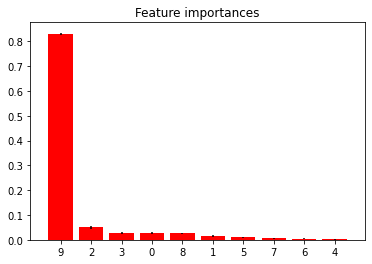

0: pickup_longitude, 1: pickup_latitude, 2: dropoff_longitude, 3: dropoff_latitude, 4: passenger_count, 5: hour, 6: weekday, 7: month, 8: year, 9: distance


In [ ]:
impact_model(rf_skl)

print("0: pickup_longitude, 1: pickup_latitude, 2: dropoff_longitude, 3: dropoff_latitude, 4: passenger_count, 5: hour, 6: weekday, 7: month, 8: year, 9: distance")

In [ ]:
model_save(y_pred, "/RandomForest.csv")

,key,fare_amount
0,2015-01-27 13:08:24.0000002,13.994330
1,2015-01-27 13:08:24.0000003,7.703254
2,2011-10-08 11:53:44.0000002,7.108422
3,2012-12-01 21:12:12.0000002,10.559744
4,2012-12-01 21:12:12.0000003,7.959981


The Random Forest Model illustrates the runtime difference for this small data set of 500,000 lines. While the model takes 25.2 seconds on the CPU, it takes only 1.24s on the GPU. This is already 20 times faster. It can also be seen that the influence of a single attribute (distance) is very large, while the other values have relatively little effect.

# 8. Comparing CPU and GPU Ridge Regression

In [ ]:
from cuml.linear_model import Ridge as cuRidge
from sklearn.linear_model import Ridge as skRidge

CPU

In [ ]:
%%time
ridge_sk = skRidge(fit_intercept=False, normalize=True, alpha=0.1)

ridge_sk.fit(X_train_lr, y_train_lr)

CPU times: user 65.1 ms, sys: 7.01 ms, total: 72.1 ms
Wall time: 88.3 ms


Ridge(alpha=0.1, fit_intercept=False, normalize=True)

In [ ]:
%%time
predict_sk= ridge_sk.predict(X_test_lr)

CPU times: user 6.37 ms, sys: 29 µs, total: 6.4 ms
Wall time: 5.23 ms


In [ ]:
%%time
r2_score_sk = r2_score(y_test_lr, predict_sk)

CPU times: user 1.05 ms, sys: 2.01 ms, total: 3.05 ms
Wall time: 2.78 ms


GPU

In [ ]:
%%time
# Eig is the faster algorithm, but svd is more accurate.
# In general svd uses significantly more memory and is slower than eig.
# If using CUDA 10.1, the memory difference is even bigger than in the other supported CUDA versions
ridge_cuml = cuRidge(fit_intercept=False, normalize=True, solver='eig', alpha=0.1)

ridge_cuml.fit(X_train, y_train)

CPU times: user 12.4 ms, sys: 3.97 ms, total: 16.4 ms
Wall time: 17 ms


Ridge(alpha=0.1, solver='eig', fit_intercept=False, normalize=True, handle=<cuml.common.handle.Handle object at 0x7fb454712b10>, output_type='cudf')

In [ ]:
%%time
predict_cuml = ridge_cuml.predict(X_test)

CPU times: user 4.38 ms, sys: 888 µs, total: 5.26 ms
Wall time: 8.09 ms


In [ ]:
%%time
r2_score_cuml = r2_score(y_test, predict_cuml)

CPU times: user 1.18 ms, sys: 13 µs, total: 1.19 ms
Wall time: 1.2 ms


In [ ]:
print("R^2 score (SKL):  %s" % r2_score_sk)
print("R^2 score (cuML): %s" % r2_score_cuml)

R^2 score (SKL):  0.6404445767402649
R^2 score (cuML): 0.6214630007743835


# 9. XGBoost running on GPU

In [ ]:
#Model Params Set 1

#MAX_TREE_DEPTH = 14
#MIN_CHILD_WEIGHT = 6
#TREE_METHOD = "hist"
#ITERATIONS = 120 
#SUBSAMPLE = 0.9
#REGULARIZATION = 1.4
#GAMMA = 0.2
#POS_WEIGHT = 0.8
#EARLY_STOP = 20 #avoid overfitting
#N_ESTIMATORS = 200
#LEARNING = 0.075

In [ ]:
#Model Params Set 2
MAX_TREE_DEPTH = 12
MIN_CHILD_WEIGHT = 2
TREE_METHOD = "hist"
ITERATIONS = 300
SUBSAMPLE = 0.9
REGULARIZATION = 1.4
GAMMA = 0.4 
POS_WEIGHT = 0.8
EARLY_STOP = 20 #avoid overfitting
N_ESTIMATORS = 1000
LEARNING = 0.15

In [ ]:
# load into cuDF Dataframe / made a copy, in order to continue working on the original data

gdf_train = X_train
gdf_train_target = y_train

gdf_eval = X_test
gdf_eval_target = y_test

print("Moved data to GPU")

Moved data to GPU


In [ ]:
#inpired by https://medium.com/rapids-ai/a-new-official-dask-api-for-xgboost-e8b10f3d1eb7
import time
import itertools

# GPU, with using cuDF

start_time = time.time()

xgtrain = xgb.DMatrix(gdf_train, gdf_train_target)
xgeval = xgb.DMatrix(gdf_eval, gdf_eval_target)

params = {'tree_method': "gpu_"+TREE_METHOD, 'max_depth': MAX_TREE_DEPTH, 'alpha': REGULARIZATION, 'min_child_weight': MIN_CHILD_WEIGHT,
          'gamma': GAMMA, 'subsample': SUBSAMPLE, 'scale_pos_weight': POS_WEIGHT, 'learning_rate': LEARNING, 'n_estimators': N_ESTIMATORS, 'silent': 1}

bst = xgb.train(params, xgtrain, ITERATIONS, evals=[(xgtrain, "train"), (xgeval, "eval")],
                early_stopping_rounds=EARLY_STOP)

timetaken_gpu = time.time() - start_time

[15:17:15] WARNING: /conda/conda-bld/xgboost_1591204502249/work/src/learner.cc:480: 
Parameters: { n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:12.47494	eval-rmse:12.43958
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[1]	train-rmse:10.79785	eval-rmse:10.80512
[2]	train-rmse:9.39314	eval-rmse:9.44959
[3]	train-rmse:8.22268	eval-rmse:8.33384
[4]	train-rmse:7.25046	eval-rmse:7.41913
[5]	train-rmse:6.44520	eval-rmse:6.68097
[6]	train-rmse:5.78514	eval-rmse:6.08628
[7]	train-rmse:5.24650	eval-rmse:5.61848
[8]	train-rmse:4.80788	eval-rmse:5.25223
[9]	train-rmse:4.45710	eval-rmse:4.96703
[10]	train-rmse:4.17545	eval-rmse:4.74837
[11]	train-rmse:3.95

In [ ]:
print("\nGPU + cuDF Time Taken:\n", round(timetaken_gpu,1))


GPU + cuDF Time Taken:
 13.3


In [ ]:
pred_DGX = xgb.DMatrix(test)
y_pred = bst.predict(pred_DGX)

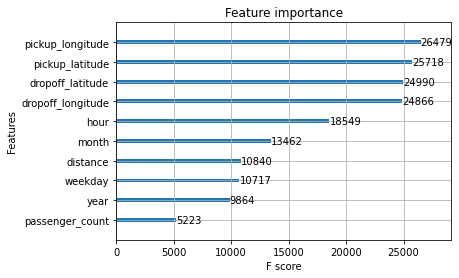

In [ ]:
from matplotlib import pyplot as plt
from xgboost import plot_importance

plot_importance(bst)
plt.show()

The above diagram illustrates the respective influence of individual parameters on the model. It is noticeable that, in contrast to the other approaches, the distance plays a much smaller role. Instead, the coordinates are in focus.

In [ ]:
model_save(y_pred,"/XGBoost.csv")

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.917575
1,2015-01-27 13:08:24.0000003,9.641943
2,2011-10-08 11:53:44.0000002,5.166448
3,2012-12-01 21:12:12.0000002,9.284602
4,2012-12-01 21:12:12.0000003,17.013460


# 10. XGBoost CPU

In [ ]:
%%time

model=xgb.XGBRegressor()
model.fit(X_train_lr, y_train_lr)

Y_pred=model.predict(data=X_test_lr)

CPU times: user 1min 15s, sys: 371 ms, total: 1min 15s
Wall time: 41.2 s


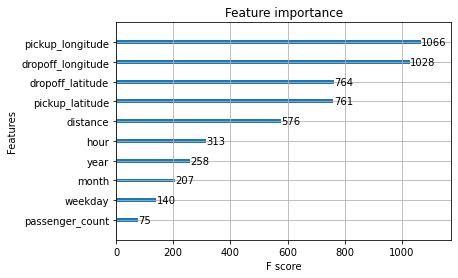

In [ ]:
from matplotlib import pyplot as plt
from xgboost import plot_importance

plot_importance(model)
plt.show()

XGBoost already took 3.3 seconds on the CPU with 50,000 records, while it took 42.2 seconds on the GPU with over 12 million records. A direct comparison was not possible, because XGBoost could not process such large amounts of data on the CPU.

# 11. LGBM model

- https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

- https://www.kaggle.com/nicapotato/taxi-rides-time-analysis-and-oof-lgbm

- https://www.kaggle.com/dsaichand3/lgbm-gpu

- https://www.kaggle.com/aerdem4/rapids-svm-on-trends-neuroimaging


Compared CPU vs GPU:
- https://www.kaggle.com/ishivinal/sklearn-rapids-pandas


## Setup LGBM with GPU Support

How to setup LGBM GPU Beta:
- https://www.kaggle.com/vinhnguyen/gpu-acceleration-for-lightgbm


this approach got some problems and ran out of runtime several times, maybe CPU/GPU in Kaggle aren't as powerful as they would need to be.

In [ ]:
!rm -r /opt/conda/lib/python3.6/site-packages/lightgbm
!git clone --recursive https://github.com/Microsoft/LightGBM
!apt-get install -y -qq libboost-all-dev

In [ ]:
%%bash
cd LightGBM
rm -r build
mkdir build
cd build
cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/ ..
make -j$(nproc)

In [ ]:
!cd LightGBM/python-package/;python3 setup.py install --precompile
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
!rm -r LightGBM

In [ ]:
%%bash
cd ..

In [ ]:
!pip install lightgbm --install-option=--gpu --force-reinstall

In [ ]:
import lightgbm as lgbm

In [ ]:
## Inspiration from https://www.kaggle.com/dsaichand3/lgbm-gpu
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.15,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 15,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':50000,
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0
    }

In [ ]:
col_cat = X_train.select_dtypes('object').columns.tolist()

d_train = lgbm.Dataset(X_train.to_pandas(), label = y_train.to_pandas(), categorical_feature = col_cat, free_raw_data=False)
d_valid = lgbm.Dataset(X_test.to_pandas(), label = y_test.to_pandas(), categorical_feature = col_cat, free_raw_data=False)

In [ ]:
%%time
lgbm_model = lgbm.train(params_1, train_set = d_train, num_boost_round=10000, early_stopping_rounds=100, verbose_eval=10, valid_sets=d_valid)

In [ ]:
y_pred = lgbm_model.predict(X_test, num_iteration = model.best_iteration)

In [ ]:
model_save(y_pred, "/LGBM.csv")

# 12. Evaluation and Discussion

It was to be recognized that there is a multiplicity of models, which are designed to be computed on several GPUs. The use of a single GPU is less popular, although not less successful. Even with small data sets the differences in runtimes can be seen. In the more detailed use and optimization of XGBoost the difference became even more significant. While the GPU processed the data set with 12 million rows without problems in less than 45 seconds, the CPU was not even able to start processing at all. 

The main difficulties were the differentiated data processing and the significantly lower number of examples for RAPIDS. Since it was rarely possible to transfer CPU models 1:1 to the GPU, there were less possibilities to compare both applications at the same time. Nevertheless, the continuous development of GPU-based models shows that this is where the future lies when CPUs reach their performance limits.

But the central problem was the lack of infrastructure. While most of the models were still running on Kaggle, Colab was hardly usable.